In [39]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

figsize=(14, 4)

random_state = 42   

from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

from utils.data_visualizator import plot_confusion_matrixes

from utils import DataAggregator
import pandas as pd

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Classifiers
Next up, we want to use classifying algorithms to predict the outcome of future matches. To do so, we will need to examine what data we have to make use of the features created in the previous notebook. First we will try to predict the outcome of the matches, we will here use grid search to find the best classifier with the best parameteres.

In [11]:
data_aggregator = DataAggregator()
df = data_aggregator.preprocess_data(data_aggregator.get_data(["E0"]), 
                                     date_column="Date",
                                     home_team_column="HomeTeam",
                                     away_team_column="AwayTeam",
                                     result_column="FTR",
                                     form_window=5)

In [12]:
df.head()

,Date,FTR,B365H,B365D,B365A,Year,Month,Day,DayOfWeek,HomeTeamWinForm,...,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,2002-08-17,0,1.727,3.25,4.333,2002,8,17,5,0.415135,...,False,False,True,False,False,False,False,False,False,False
1,2002-08-17,0,2.250,3.25,2.750,2002,8,17,5,0.356981,...,False,False,False,False,False,False,False,False,False,False
2,2002-08-17,1,1.200,5.00,12.000,2002,8,17,5,0.687770,...,False,False,False,False,False,False,True,False,False,False
3,2002-08-17,-1,2.800,3.25,2.200,2002,8,17,5,0.415556,...,False,False,False,False,False,False,False,False,False,False
4,2002-08-17,1,1.727,3.25,4.333,2002,8,17,5,0.426403,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
traget = "FTR"
df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train = df_train.drop(columns=[traget, "Date"])
y_train = df_train[traget]
X_test = df_test.drop(columns=[traget, "Date"])
y_test = df_test[traget]

print(y_train.value_counts(normalize=True), "\n", y_test.value_counts(normalize=True))

FTR
 1    0.460025
-1    0.293108
 0    0.246867
Name: proportion, dtype: float64 
 FTR
 1    0.460526
-1    0.323684
 0    0.215789
Name: proportion, dtype: float64


In [14]:
model_lbls = [
    'dt' # decision tree
    ,'nb' # gaussian naive bayes
    ,'lp'   # linear perceptron
    ,'svc'  # support vector 
    ,'knn'  # k nearest neighbours
    ,'adb'  # adaboost
    ,'rf'   # random forest
]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state), 
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-13,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state), 
           'param': [{'kernel': ['rbf'], 
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],                     
             },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state, algorithm="SAMME"),
           'param': [{'n_estimators':[10,20,30,40,50]
                     ,'learning_rate':[0.2,0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(4,10)]
                     ,'n_estimators':[*range(10,60,10)]}]
          }
}

In [15]:
best_classifiers = {}
best_scores = {}

for model_lbl in tqdm(model_lbls):
    model = models[model_lbl]
    name = model['name'].strip()
    estimator = model['estimator']
    param_grid = model['param']
    
    grid_search = GridSearchCV(estimator=estimator, 
                               param_grid=param_grid, 
                               scoring='accuracy', 
                               cv=5, 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    y_pred = best_model.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    
    best_classifiers[model_lbl] = best_model
    best_scores[model_lbl] = {
        'Best Params': best_params,
        'CV Accuracy': best_score,
        'Test Accuracy': test_score
    }


100%|██████████| 7/7 [00:39<00:00,  5.71s/it]


In [41]:
result = {}

confusion_matrixes = {}

for model_lbl in model_lbls:
    model = best_classifiers[model_lbl]
    
    y_pred = model.predict(X_test)

    full_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), pd.DataFrame(y_pred, columns=["Prediction"]).reset_index(drop=True)], axis=1)

    accuracy, won = data_aggregator.calculate_accuracy(full_df, "FTR", "Prediction")

    data_aggregator.save_metrics(f"{model_lbl}-classifier", accuracy, won)

    result[model_lbl] = [accuracy, won]

    confusion_matrixes[model_lbl] = confusion_matrix(y_test, y_pred)

In [42]:
pd.DataFrame(result, index=["Accuracy", "Won"])

,dt,nb,lp,svc,knn,adb,rf
Accuracy,0.597368,0.573684,0.215789,0.615789,0.502632,0.636842,0.631579
Won,7906.600000,7498.500000,-591.000000,7887.800000,6244.000000,8231.000000,8200.000000


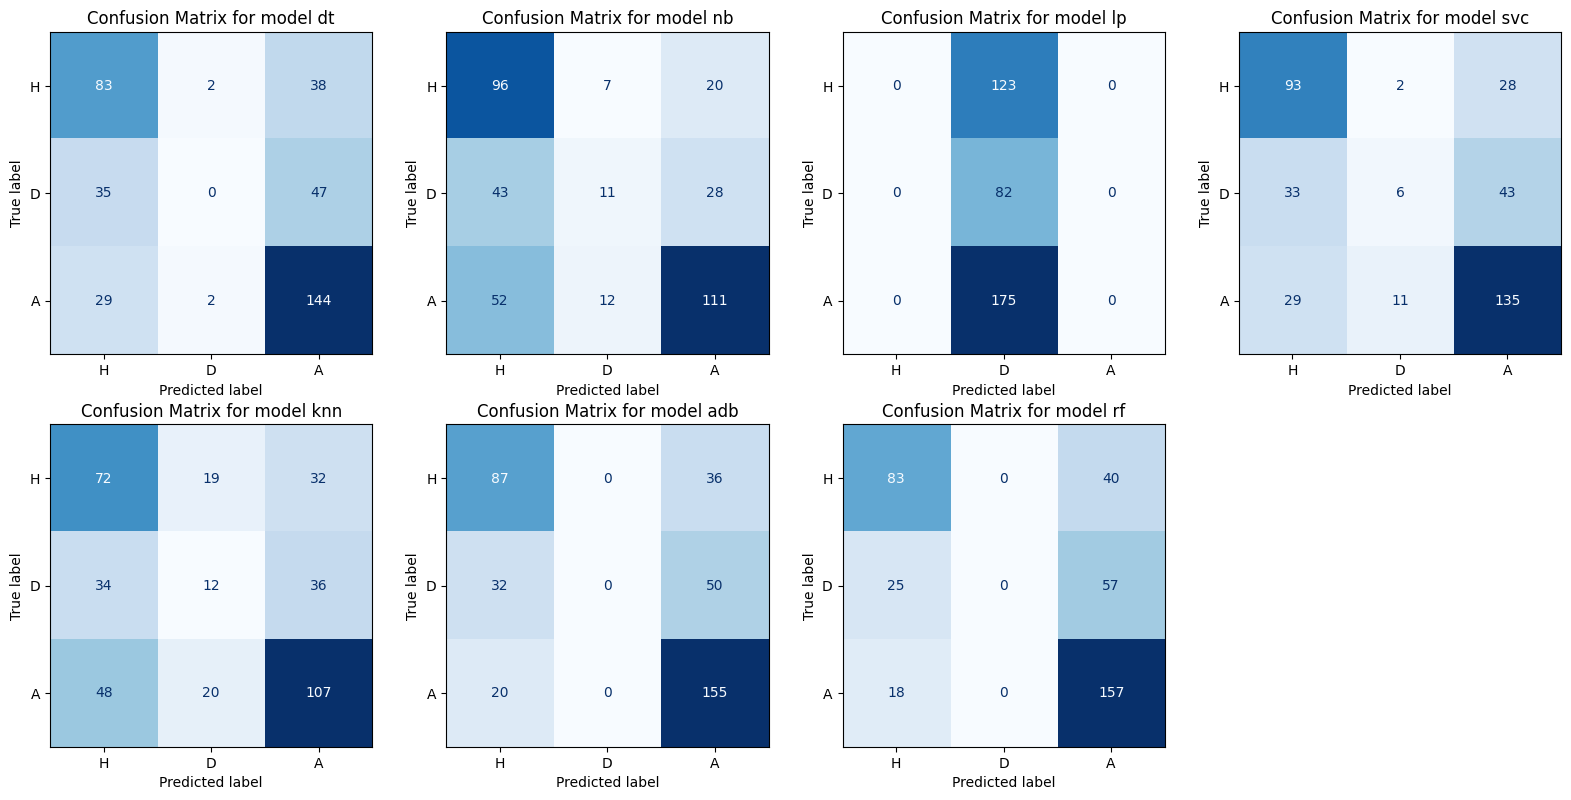

In [43]:
plot_confusion_matrixes(confusion_matrixes, classes=["H", "D", "A"])